# Feiertagseffekte

Ziel dieses Notebooks ist, den Effekt von Feiertagen auf die Häufigkeit (und Zusammensetzung) von verschiedenen Request Types herauszufinden. Dazu wurden 2 Modelle zur Regression erstell. 

Forschungsfragen
1. Gibt es einen messbaren Feiertagseffekt auf die tägliche Anzahl an 311-Meldungen?
2. Bleibt dieser Effekt bestehen, wenn wir typische Muster wie Wochentag, Monat und einen Trend berücksichtigen?
3. Ändert sich die Verteilung der Request-Typen an Feiertagen? (ist ein typ mehr vertreten?)



## 1. Daten einlesen


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_info_columns', 10_000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200_000)     # zeigt Zeileninfo, wenn nötig


# Pfad zur Datei (liegt im gleichen Ordner wie das Notebook)
path = Path("dataset/311_Service_Requests_2024.csv")

# Einfacher Import
df = pd.read_csv(path)

# 2. Datenvorbereitung
Wichtigste Variablen:

- 'df_daily' = Anzahl Requests pro Tag. enthält: DATE, count, weekday, month, trend, is_holiday
- 'is_holiday': Binärer Indikator, der den Wert 1 annimmt, wenn der betreffende Tag ein US-Feiertag ist, und 0 ansonsten.
- 'trend': Linearer Zeittrend als kontrollvariable




In [3]:
df["CREATED_DATE"] = pd.to_datetime(df["CREATED_DATE"], errors="coerce")

# Date enthält nur das Datum ohne die Uhrzeit
df["DATE"] = df["CREATED_DATE"].dt.normalize()

#liste aller Feiertage als Datum
holidays_2024 = pd.to_datetime([
    "2024-01-01", "2024-01-15", "2024-02-19", "2024-05-27",
    "2024-06-19", "2024-07-04", "2024-09-02", "2024-10-14",
    "2024-11-11", "2024-11-28", "2024-12-25"
])

# Jedem Datum den Namen geben
holiday_names = {
    pd.Timestamp("2024-01-01"): "New Year's Day",
    pd.Timestamp("2024-01-15"): "MLK Day",
    pd.Timestamp("2024-02-19"): "Presidents' Day",
    pd.Timestamp("2024-05-27"): "Memorial Day",
    pd.Timestamp("2024-06-19"): "Juneteenth",
    pd.Timestamp("2024-07-04"): "Independence Day",
    pd.Timestamp("2024-09-02"): "Labor Day",
    pd.Timestamp("2024-10-14"): "Columbus Day",
    pd.Timestamp("2024-11-11"): "Veterans Day",
    pd.Timestamp("2024-11-28"): "Thanksgiving",
    pd.Timestamp("2024-12-25"): "Christmas Day",
}


#Anzahl Requests pro Tag
df_daily = (df.groupby("DATE").size().reset_index(name="count").sort_values("DATE").reset_index(drop=True))

# Binäre Variable: 1 = Feiertag, 0 = kein Feiertag
df["is_holiday"] = df["DATE"].isin(holidays_2024).astype(int)
df_daily["is_holiday"] = df_daily["DATE"].isin(holidays_2024).astype(int)

# Name des Feiertags. empty string, falls kein Feiertag
df["holiday_name"] = df["DATE"].map(holiday_names).fillna("")
df_daily["holiday_name"] = df_daily["DATE"].map(holiday_names).fillna("") ## Name des Feiertags auf Tagesebene

# Wochentage (0= Montag,.. ,6 = Sonntag)
df_daily["weekday"] = df_daily["DATE"].dt.dayofweek

# Monat (1= Januar, .., Dezember=12)
df_daily["month"] = df_daily["DATE"].dt.month

# Linearer Zeittrend (Anzahl Tage seit Beobachtungsbeginn)
df_daily["trend"] = (df_daily["DATE"] - df_daily["DATE"].min()).dt.days

df_daily.head()


,DATE,count,is_holiday,holiday_name,weekday,month,trend
0,2024-01-01,4055,1,New Year's Day,0,1,0
1,2024-01-02,6009,0,,1,1,1
2,2024-01-03,6051,0,,2,1,2
3,2024-01-04,5625,0,,3,1,3
4,2024-01-05,5479,0,,4,1,4


## 2.  Wiederholung; Verteilung der Häufigkeiten von Meldungen über das Jahr 

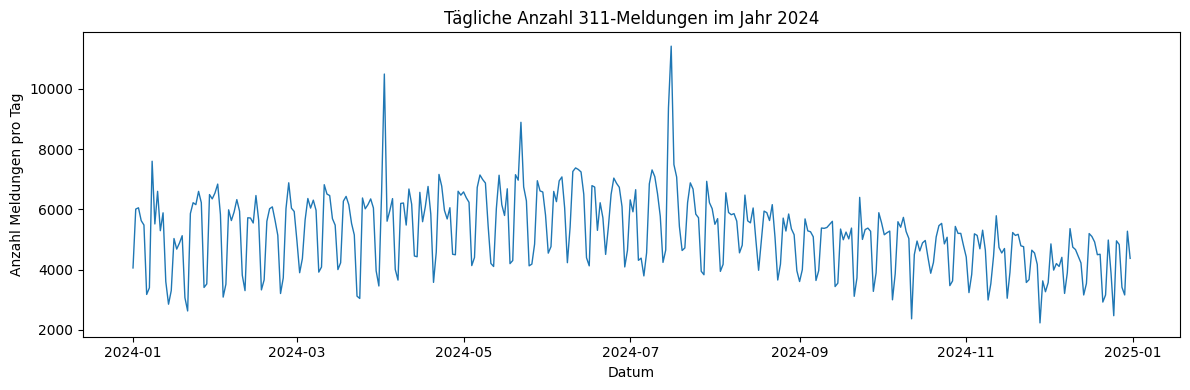

In [4]:

plt.figure(figsize=(12, 4))
plt.plot(df_daily["DATE"], df_daily["count"], linewidth=1)

plt.title("Tägliche Anzahl 311-Meldungen im Jahr 2024")
plt.xlabel("Datum")
plt.ylabel("Anzahl Meldungen pro Tag")

plt.tight_layout()
plt.show()


Da die Werte stark schwanken, wurde ein 7-Tage-Gleitmittel zusätzlich eingezeichnet

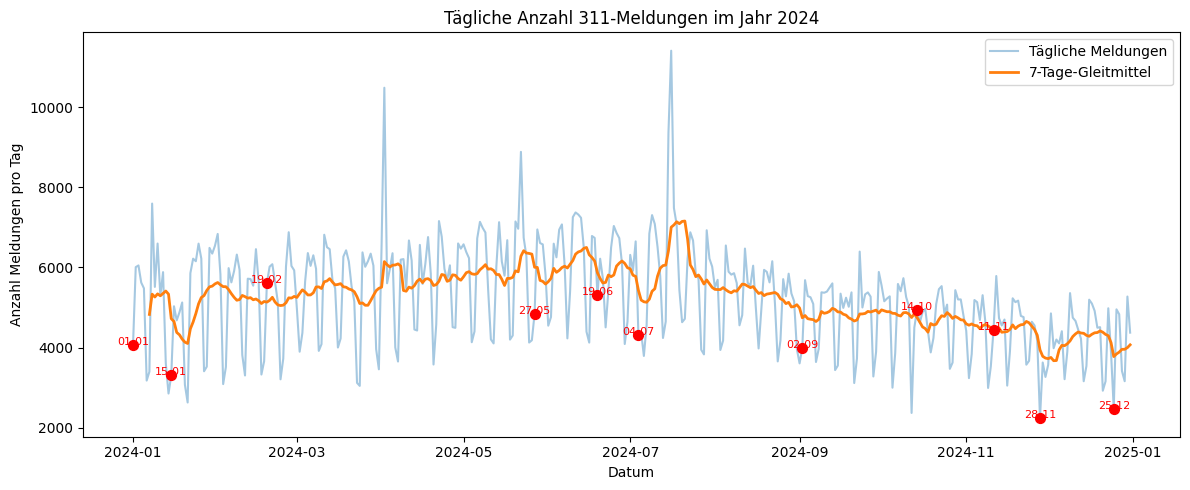

In [5]:
df_daily["count_ma7"] = df_daily["count"].rolling(window=7).mean() #Rolling=7 erstellt ein rollendes Fenster mit Grösse 7

plt.figure(figsize=(12, 5))
plt.plot(df_daily["DATE"], df_daily["count"], alpha=0.4, label="Tägliche Meldungen")
plt.plot(df_daily["DATE"], df_daily["count_ma7"], linewidth=2, label="7-Tage-Gleitmittel")
for holiday in holidays_2024:
    # Finde den Index, der dem Datum entspricht
    idx = df_daily.index[df_daily['DATE'] == holiday]
    if not idx.empty:
        # Markiere den Punkt
        plt.scatter(df_daily.loc[idx, 'DATE'], df_daily.loc[idx, 'count'], color='red', s=50, zorder=5)
        # Optional: Text hinzufügen
        plt.text(df_daily.loc[idx, 'DATE'].values[0], df_daily.loc[idx, 'count'].values[0] + 2, 
                 holiday.strftime('%d-%m'), color='red', fontsize=8, ha='center')

plt.title("Tägliche Anzahl 311-Meldungen im Jahr 2024")
plt.xlabel("Datum")
plt.ylabel("Anzahl Meldungen pro Tag")
plt.legend()

plt.tight_layout()
plt.show()


Auf der x-Achse ist das Datum, auf der y-Achse die Zahl der 311-Meldungen pro Tag. Die roten Markierungen stellen die Feiertage dar. 
Man erkennt einen klaren Wochenrhythmus und saisonale Muster über das Jahr.
Einzelne Feiertage fallen als starke Einbrüche im Zeitverlauf auf.
Diese Struktur motiviert ein Regressionsmodell mit Wochentag, Monat und Trend als erklärende Variablen.

# 3. Modellierung: Regression auf Tagesebene

Wir schätzen zwei lineare Modelle auf Tagesebene.

- **Modell 1 (Baseline / „normaler Tag“):** erklärt die Anzahl der Meldungen durch Wochentag, Monat und Trend.
- **Modell 2 (mit Feiertagsdummy):** ergänzt mit dem Dummy `is_holiday` und quantifiziert den zusätzlichen Feiertagseffekt.


# 3.1 Modell 1: normaler Tag

Das Modell zeigt die Anzahl erwarteter Meldungen, wäre der Feiertag ein normaler Tag. Wir sagen also voraus, wie viele Meldungen an diesem Tag hineinkommen würden, wäre dieser Tag ein normaler Tag gewesen.  

- **Formel**: count ~ C(weekday) + C(month) + trend


In [6]:
# Modell 1: ohne Feiertag
m1 = smf.ols("count ~ C(weekday) + C(month) + trend", data=df_daily).fit()
print("Modell 1 (ohne Feiertag):")
print(m1.summary())

Modell 1 (ohne Feiertag):
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     52.27
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           3.19e-87
Time:                        19:56:51   Log-Likelihood:                -2894.0
No. Observations:                 366   AIC:                             5826.
Df Residuals:                     347   BIC:                             5900.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

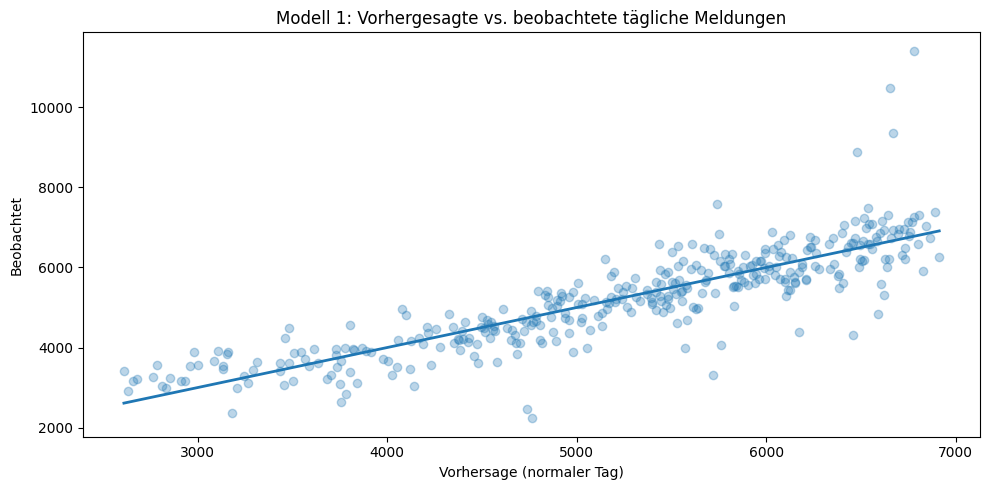

In [7]:
# Vorhersagen + Residuen (Modell 1: normaler Tag)
df_daily["pred_m1"] = m1.predict(df_daily)
df_daily["resid_m1"] = df_daily["count"] - df_daily["pred_m1"]

plt.figure(figsize=(10, 5))
plt.scatter(df_daily["pred_m1"], df_daily["count"], alpha=0.3)
plt.plot([df_daily["pred_m1"].min(), df_daily["pred_m1"].max()],
         [df_daily["pred_m1"].min(), df_daily["pred_m1"].max()],
         linewidth=2)

plt.title("Modell 1: Vorhergesagte vs. beobachtete tägliche Meldungen")
plt.xlabel("Vorhersage (normaler Tag)")
plt.ylabel("Beobachtet")
plt.tight_layout()
plt.show()

### 3.1.1 Graphische Darstellung des Effekts

Hier betrachten wir die Differenz zwischen beobachtetem Wert und der Baseline‑Vorhersage an Feiertagen.

- `effect = count - pred_m1`
- Positive Werte: mehr Meldungen als erwartet
- Negative Werte: weniger Meldungen als erwartet

In [8]:
holiday_df = df_daily[df_daily["is_holiday"] == 1].copy()
holiday_df["effect"] = holiday_df["count"] - holiday_df["pred_m1"]

holiday_df[["DATE", "holiday_name", "count", "pred_m1", "effect"]].sort_values("DATE")

,DATE,holiday_name,count,pred_m1,effect
0,2024-01-01,New Year's Day,4055,5764.043109,-1709.043109
14,2024-01-15,MLK Day,3303,5717.180120,-2414.180120
49,2024-02-19,Presidents' Day,5605,5940.618412,-335.618412
147,2024-05-27,Memorial Day,4846,6590.432693,-1744.432693
170,2024-06-19,Juneteenth,5302,6621.751395,-1319.751395
185,2024-07-04,Independence Day,4307,6456.267827,-2149.267827
245,2024-09-02,Labor Day,3998,5573.678422,-1575.678422
287,2024-10-14,Columbus Day,4948,5419.321159,-471.321159
315,2024-11-11,Veterans Day,4445,5069.644166,-624.644166
332,2024-11-28,Thanksgiving,2231,4762.134928,-2531.134928


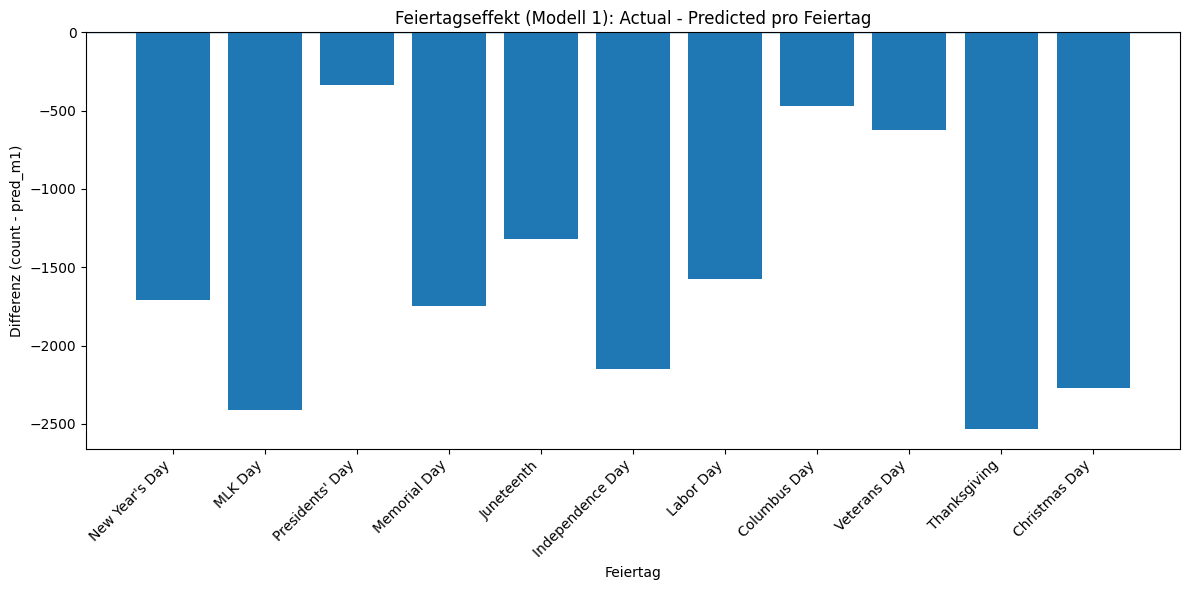

In [9]:
# Balkendiagramm: Feiertagseffekt (tatsächlich – vorhergesagt) pro Feiertag
plt.figure(figsize=(12, 6))
plt.bar(holiday_df["holiday_name"], holiday_df["effect"])
plt.axhline(0, linewidth=1)

plt.title("Feiertagseffekt (Modell 1): Actual - Predicted pro Feiertag")
plt.ylabel("Differenz (count - pred_m1)")
plt.xlabel("Feiertag")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

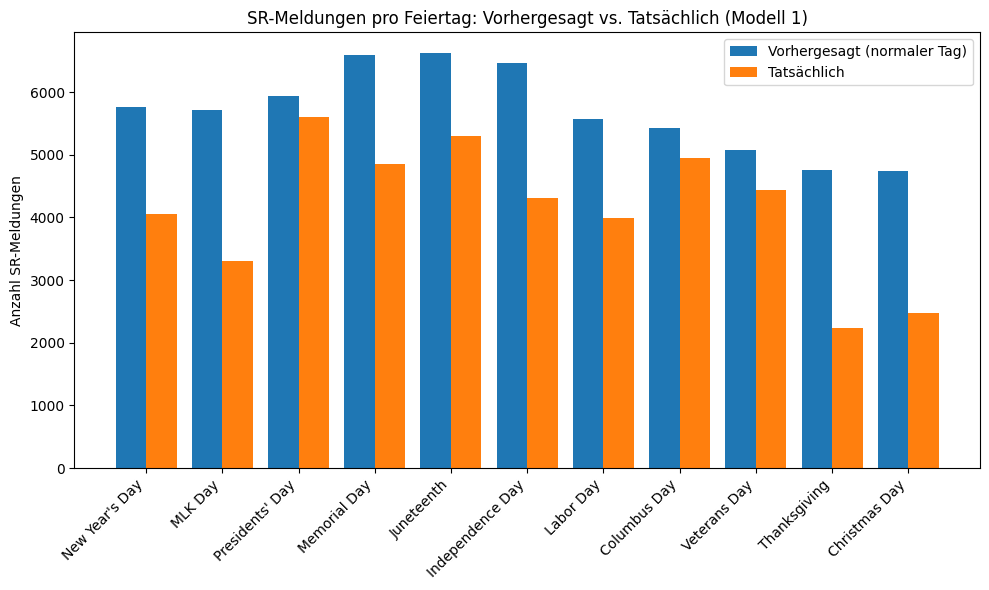

,holiday_name,pred_m1,count,effect
0,New Year's Day,5764.043109,4055,-1709.043109
14,MLK Day,5717.180120,3303,-2414.180120
49,Presidents' Day,5940.618412,5605,-335.618412
147,Memorial Day,6590.432693,4846,-1744.432693
170,Juneteenth,6621.751395,5302,-1319.751395
185,Independence Day,6456.267827,4307,-2149.267827
245,Labor Day,5573.678422,3998,-1575.678422
287,Columbus Day,5419.321159,4948,-471.321159
315,Veterans Day,5069.644166,4445,-624.644166
332,Thanksgiving,4762.134928,2231,-2531.134928


In [10]:
# Plot: Vorhergesagt vs. Tatsächlich pro Feiertag
import numpy as np


holiday_df_sorted = holiday_df.sort_values("DATE").copy()

x = np.arange(len(holiday_df_sorted))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, holiday_df_sorted["pred_m1"], width=width, label="Vorhergesagt (normaler Tag)")
plt.bar(x + width/2, holiday_df_sorted["count"], width=width, label="Tatsächlich")

plt.xticks(x, holiday_df_sorted["holiday_name"], rotation=45, ha="right")
plt.ylabel("Anzahl SR-Meldungen")
plt.title("SR-Meldungen pro Feiertag: Vorhergesagt vs. Tatsächlich (Modell 1)")
plt.legend()
plt.tight_layout()
plt.show()

holiday_df_sorted[["holiday_name", "pred_m1", "count", "effect"]]

# 3.2 Modell 2: mit Feiertagsdummy

Zeigt uns, ob die Feiertage einen zusätzlichen effekt haben. Es beantworted die Frage: Wie viele Meldungen mehr oder weniger gibt es an einem Feiertag,
verglichen mit einem normalen Tag gleichen Wochentags, Monats und Zeitpunkts?

count = f(weekday, month, trend, is_holiday)


In [11]:
# Modell 2: mit Feiertagsdummy
m2 = smf.ols("count ~ C(weekday) + C(month) + trend + is_holiday", data=df_daily).fit()
print("\nModell 2 (mit Feiertag):")
print(m2.summary())


Modell 2 (mit Feiertag):
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     65.26
Date:                Sat, 03 Jan 2026   Prob (F-statistic):          5.69e-102
Time:                        19:56:51   Log-Likelihood:                -2855.4
No. Observations:                 366   AIC:                             5751.
Df Residuals:                     346   BIC:                             5829.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

In [12]:
print(m2.pvalues["is_holiday"])


1.332479441663812e-17


## 3.3 Residuenplot von Modell

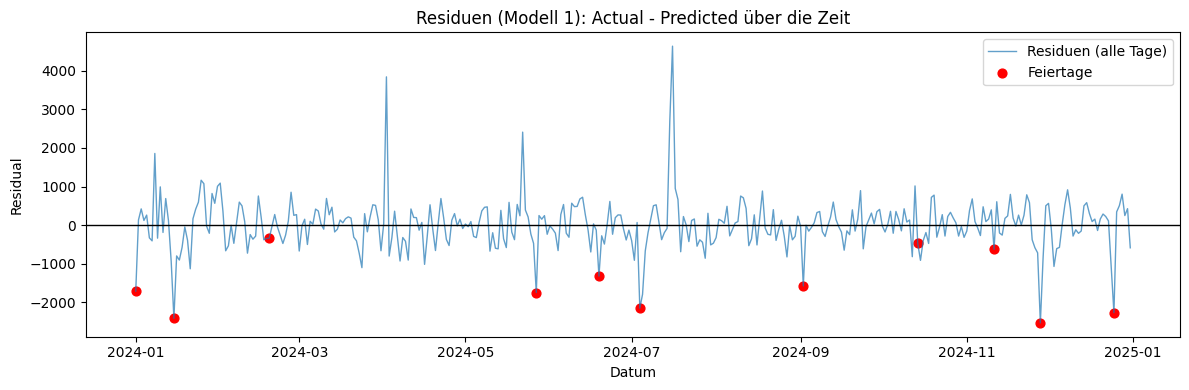

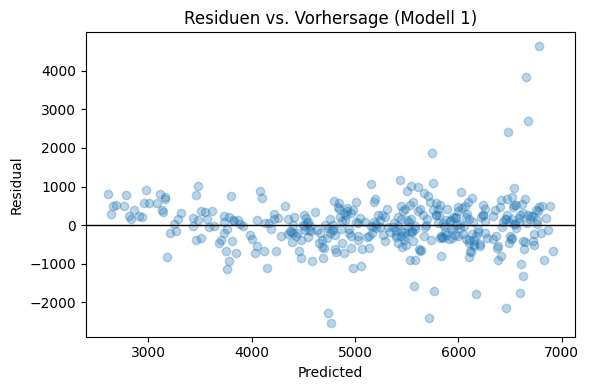

In [13]:
# Residuen von Modell 1 (der tatsächliche minus den vorhergesagten)
df_daily["resid_m1"] = df_daily["count"] - df_daily["pred_m1"]


# Feiertage auf Tagesebene
holiday_days = df_daily[df_daily["is_holiday"] == 1].copy()

# über die Zeit
plt.figure(figsize=(12, 4))
plt.plot(df_daily["DATE"], df_daily["resid_m1"], linewidth=1, alpha=0.7, label="Residuen (alle Tage)")
plt.scatter(holiday_days["DATE"], holiday_days["resid_m1"], color="red", s=40, label="Feiertage")
plt.axhline(0, color="black", linewidth=1)

plt.title("Residuen (Modell 1): Actual - Predicted über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


# Residuen vs. Fitted (Modell 1)
plt.figure(figsize=(6, 4))
plt.scatter(df_daily["pred_m1"], df_daily["resid_m1"], alpha=0.3)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuen vs. Vorhersage (Modell 1)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()



### Interpretation der Residuenplots

Im Residuen-vs.-Vorhersage-Plot ist eine Trichterform erkennbar. 

Das deutet auf Heteroskedastizität hin: Bei höheren vorhergesagten Werten streuen die Residuen stärker als bei kleineren vorhergesagten Werten. Das ist normal für Zähldaten, da die Varianz mit dem Niveau der Zielvariable zunimmt.



# 4. SR-Types Analyse

Hier wird geprüft, ob sich die Zusammensetzung der Request Types an Feiertagen gegenüber normalen Tagen unterscheidet. 



## 4.1 χ² - Test

In [14]:
from scipy.stats import chi2_contingency

cont = pd.crosstab(df["is_holiday"], df["SR_TYPE"])
chi2, p, dof, expected = chi2_contingency(cont)

print("χ²:", chi2)
print("p-Wert:", p)
print("df:", dof)

χ²: 4428.915275244082
p-Wert: 0.0
df: 106


Der kleine p wert bedeuted, dass die Verteilungen nicht exakt gleich sind.

Problem aus der Vorlesung: Da der Test bei grossem n bereits bei kleinen Unterschieden signifikant wird. Deshalb werden zusätzlich die relativen Anteile der einzelnen SR_TYPE an Feiertagen und Nicht-Feiertagen verglichen.


## 4.2 Vergleich relativer Anteil

Berechnung der prozentualen Anteilen der Request Types an Feiertagen vs. an normalen Tagen und die Differenz. Wir zeigen jeweils die 15 stärksten Über-/Unterrepräsentationen (die mit der grössten Differenzen).

In [15]:
total_holiday = (df["is_holiday"] == 1).sum()
total_nonholiday = (df["is_holiday"] == 0).sum()

holiday_counts = df.loc[df["is_holiday"] == 1, "SR_TYPE"].value_counts()
nonholiday_counts = df.loc[df["is_holiday"] == 0, "SR_TYPE"].value_counts()
#prozentualer anteil berechnen
holiday_percent = (holiday_counts / total_holiday * 100).rename("Holiday_%")
nonholiday_percent = (nonholiday_counts / total_nonholiday * 100).rename("NonHoliday_%")

comparison = pd.concat([holiday_percent, nonholiday_percent], axis=1).fillna(0)
comparison["Diff_%"] = comparison["Holiday_%"] - comparison["NonHoliday_%"]

print("Top SR Types (Feiertage häufiger):")
display(comparison.sort_values("Diff_%", ascending=False).head(15))

print("Top SR Types (Feiertage seltener):")
display(comparison.sort_values("Diff_%").head(15))

Top SR Types (Feiertage häufiger):


,Holiday_%,NonHoliday_%,Diff_%
SR_TYPE,,,
311 INFORMATION ONLY CALL,42.681667,35.653493,7.028174
Aircraft Noise Complaint,23.287701,17.833196,5.454505
No Water Complaint,0.520776,0.196155,0.324621
Open Fire Hydrant Complaint,0.652618,0.362071,0.290548
Buildings - Plumbing Violation,0.573513,0.428437,0.145076
Yard Waste Pick-Up Request,0.909710,0.782426,0.127284
Stray Animal Complaint,0.751500,0.674902,0.076598
Report an Injured Animal,0.580105,0.511609,0.068496
Vicious Animal Complaint,0.421895,0.367476,0.054418


Top SR Types (Feiertage seltener):


,Holiday_%,NonHoliday_%,Diff_%
SR_TYPE,,,
Graffiti Removal Request,3.212551,5.239935,-2.027384
Tree Trim Request (NO LONGER BEING ACCEPTED),0.516381,2.279948,-1.763566
Garbage Cart Maintenance,1.733723,2.586785,-0.853062
Tree Debris Clean-Up Request,1.012986,1.792424,-0.779437
Rodent Baiting/Rat Complaint,1.654618,2.407328,-0.752710
Tree Emergency,0.806434,1.494311,-0.687877
Pothole in Street Complaint,2.017183,2.693452,-0.676269
Abandoned Vehicle Complaint,2.109473,2.624035,-0.514562
Tree Removal Inspection,0.584500,1.093116,-0.508616


## 4.3 Barplot

Zeigt die 10 Types die am meisten öfters und weniger eintreten.  

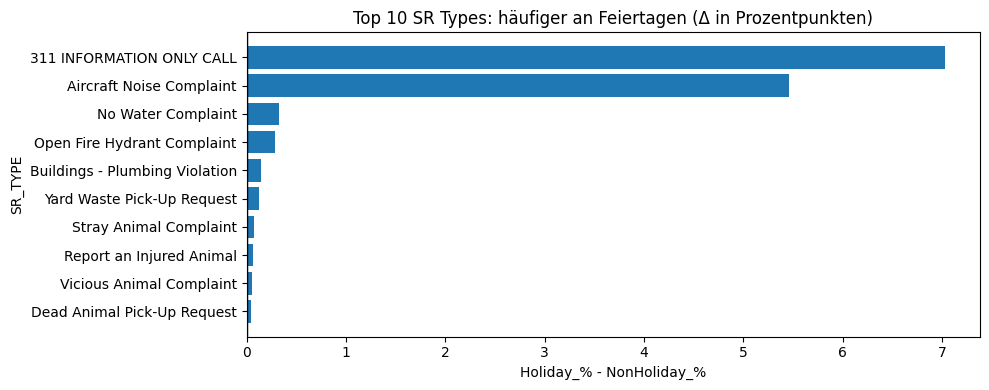

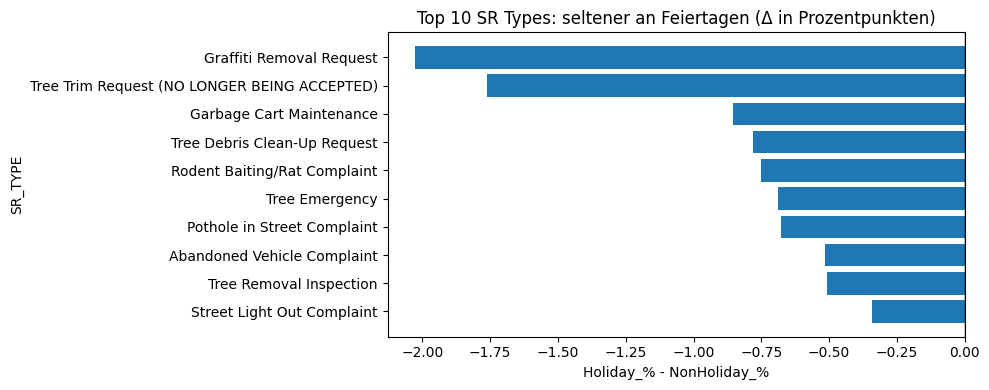

In [16]:
top_up = comparison.sort_values("Diff_%", ascending=False).head(10)
top_down = comparison.sort_values("Diff_%", ascending=True).head(10)

plt.figure(figsize=(10, 4))
plt.barh(top_up.index[::-1], top_up["Diff_%"][::-1])
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 10 SR Types: häufiger an Feiertagen (Δ in Prozentpunkten)")
plt.xlabel("Holiday_% - NonHoliday_%")
plt.ylabel("SR_TYPE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.barh(top_down.index[::-1], top_down["Diff_%"][::-1])
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 10 SR Types: seltener an Feiertagen (Δ in Prozentpunkten)")
plt.xlabel("Holiday_% - NonHoliday_%")
plt.ylabel("SR_TYPE")
plt.tight_layout()
plt.show()


## 4.3 Heatmap 

Die Heatmap zeigt die relative Änderung des Anteils einzelner SR_TYPES an Feiertagen im Vergleich zu Nicht-Feiertagen.

Berechnungsidee:
- Für jeden Feiertag wird der Anteil eines SR_TYPE an allen Meldungen dieses Feiertags berechnet (in %).
- Als Baseline dient der Anteil desselben SR_TYPE an allen Nicht-Feiertagen (in %).
- Die Heatmap zeigt die relative Änderung in Prozent


Zur besseren Lesbarkeit werden nur SR_TYPES berücksichtigt, die an Nicht-Feiertagen im Durchschnitt mindestens 0.5 Meldungen pro Tag haben, und es werden die Top 10 SR_TYPES mit dem grössten durchschnittlichen Anstieg(Pct_Change > 0) gezeigt.


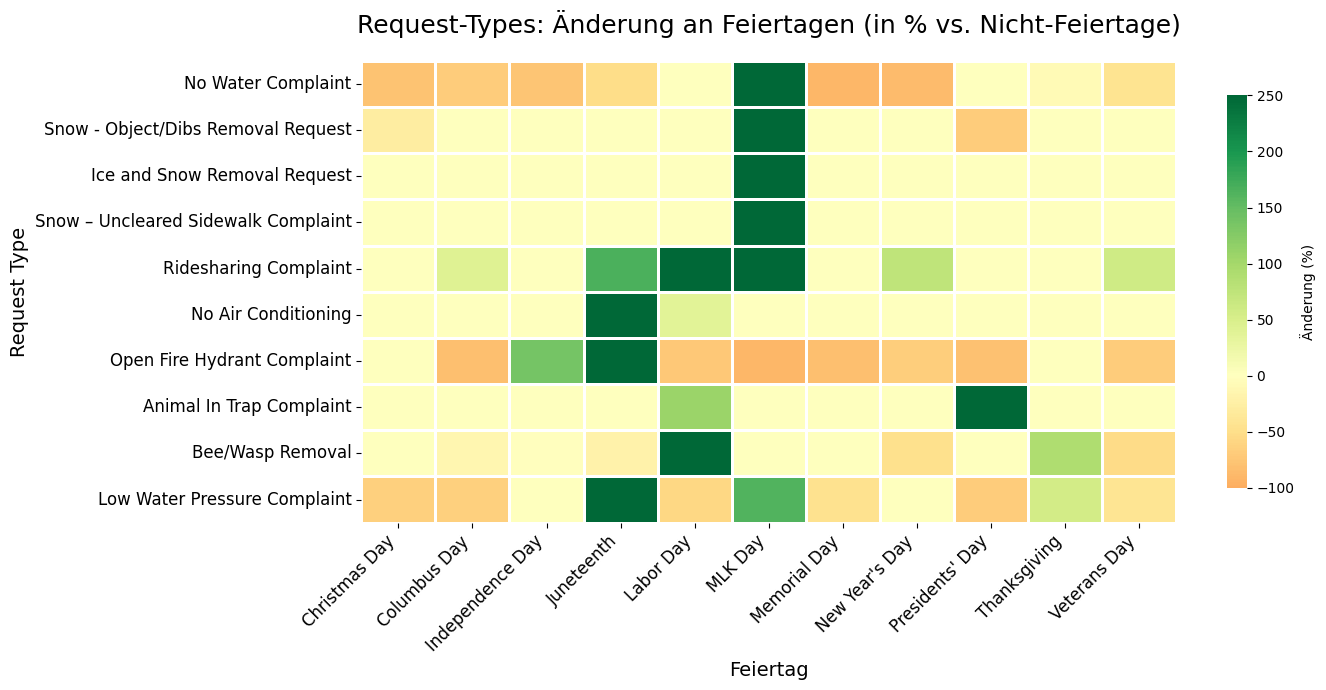

In [17]:

# Feiertage vs. Nicht-Feiertage
df_hol = df[df["is_holiday"] == 1].copy()
df_non = df[df["is_holiday"] == 0].copy()

# Baseline: Anteil je SR_TYPE an Nicht-Feiertagen (in %)
non_pct = df_non["SR_TYPE"].value_counts(normalize=True) * 100

# Anteil je SR_TYPE pro Feiertag (in %)
tmp = (df_hol.groupby(["holiday_name", "SR_TYPE"]).size().reset_index(name="n"))

# Gesamtzahl Meldungen pro Feiertag
tot = (df_hol.groupby("holiday_name").size().reset_index(name="tot"))

# Zusammenführen
tmp = tmp.merge(tot, on="holiday_name")

# Prozentanteil je SR_TYPE am jeweiligen Feiertag
tmp["holiday_pct"] = tmp["n"] / tmp["tot"] * 100

# Relative Änderung gegenüber Nicht-Feiertagen (in %)
tmp["non_pct"] = tmp["SR_TYPE"].map(non_pct)
tmp["Pct_Change"] = (tmp["holiday_pct"] - tmp["non_pct"]) / tmp["non_pct"] * 100


# Relevanzfilter: SR_TYPE muss an Nicht-Feiertagen
# im Schnitt > 0.5 Meldungen pro Tag haben

n_non_days = df_daily.loc[df_daily["is_holiday"] == 0, "DATE"].nunique()
min_non_count = 0.5 * n_non_days
relevant_types = df_non["SR_TYPE"].value_counts()
relevant_types = relevant_types[relevant_types > min_non_count].index

tmp = tmp[tmp["SR_TYPE"].isin(relevant_types)].copy()


# Top 10 SR_TYPE nach durchschnittlichem positiven Anstieg

pos = tmp[tmp["Pct_Change"] > 0]
top_types = (pos.groupby("SR_TYPE")["Pct_Change"].mean().sort_values(ascending=False).head(10).index)

# Pivot für Heatmap
pivot = (tmp[tmp["SR_TYPE"].isin(top_types)].pivot(index="SR_TYPE", columns="holiday_name", values="Pct_Change").fillna(0))

# Sortierung: stärkster durchschnittlicher Effekt oben
pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

# Plotten
plt.figure(figsize=(14, 7))
sns.heatmap(
    pivot,
    cmap="RdYlGn",
    center=0,
    linewidths=0.8,
    linecolor="white",
    cbar_kws={"label": "Änderung (%)", "shrink": 0.85},
    vmin=-100,
    vmax=250
)

plt.title("Request-Types: Änderung an Feiertagen (in % vs. Nicht-Feiertage)", fontsize=18, pad=20)
plt.xlabel("Feiertag", fontsize=14)
plt.ylabel("Request Type", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


## 5 Fallnotiz



| Regel / Analyse | Schwelle / Grund | Datum | Ergebnis | Entscheidung | Anmerkung |
| --- | --- | --- | --- | --- | --- |
| Lineare Regression (Modell 1) | count ~ weekday + month + trend | 30.11.25 | Vorhergesagt vs. Tatsächlich Häufigkeit der Meldungen pro Feiertag | Baseline-Modell definiert | (R-squared: 0.731) |
| Multiple Regression (Modell 2) | Erweiterung um mehrere erklärende Variablen | 30.11.25 | R-squared: 0.782 | Modell erklärt 78% der Varianz | Das Modell kann beibehalten werde, da es gut ist (erklärt Grösstteil der Varianz) |
| Feiertagseffekt (Regression) | Dummy= is_holiday | 01.12.25 | Signifikanter Effekt festgestellt | Interpretation als Durchschnittsunterschied | Keine Kausalinterpretation |
| Chi-Quadrat-Test | Vergleich SR_TYPE × Feiertag | 01.12.25 | p-Wert=0 | Effektgrössen zusätzlich analysiert | Bei grossem n ist der p-Wert klein, weshalb der Test nicht aussagekräftig ist |



